In [9]:
# Imports
import os
from io import StringIO
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [10]:
# Load ARFF-like file without relying on scipy to keep dependencies minimal.
data_path = os.path.join('PhishingData.arff')
with open(data_path,'r') as f:
    lines = f.readlines()
# Find the @data marker (case-insensitive)
start = 0
for idx,ln in enumerate(lines):
    if ln.strip().lower().startswith('@data'):
        start = idx+1
        break
data_lines = [ln for ln in lines[start:] if ln.strip()!='']
data_txt = ''.join(data_lines)
df = pd.read_csv(StringIO(data_txt), header=None)
# Column names from the ARFF header (checked in file)
df.columns = ['SFH','popUpWidnow','SSLfinal_State','Request_URL','URL_of_Anchor','web_traffic','URL_Length','age_of_domain','having_IP_Address','Result']
print('Data shape:', df.shape)
print('Class distribution:')
print(df['Result'].value_counts())
df.head()

Data shape: (1353, 10)
Class distribution:
Result
-1    702
 1    548
 0    103
Name: count, dtype: int64


,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1


In [11]:
# Preprocessing: convert to numeric, map labels, handle missing (if any)
# Assumption: Result==1 => positive (phishing), else negative (0).
X = df.drop('Result', axis=1).astype(float)
y = df['Result'].map(lambda v: 1 if v==1 else 0).astype(int)
print('Positive class count:', y.sum(), 'out of', len(y))
# Train/test split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Train/test sizes:', X_train.shape, X_test.shape)

Positive class count: 548 out of 1353
Train/test sizes: (1082, 9) (271, 9)


In [12]:
# Model configuration 1: small network (baseline)
mlp1 = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', alpha=0.0001, learning_rate_init=0.001, max_iter=500, random_state=42)
mlp1.fit(X_train_scaled, y_train)
y1_pred = mlp1.predict(X_test_scaled)
print('MLP1 trained')
print('Accuracy:', accuracy_score(y_test, y1_pred))
print('Classification report (MLP1):')
print(classification_report(y_test, y1_pred))

MLP1 trained
Accuracy: 0.8966789667896679
Classification report (MLP1):
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       161
           1       0.84      0.93      0.88       110

    accuracy                           0.90       271
   macro avg       0.89      0.90      0.89       271
weighted avg       0.90      0.90      0.90       271



/Users/shreyjain/Documents/CODING/MCA-Assignments/Trimester-5/nndl/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
# Model configuration 2: deeper/wider network with higher LR and slight regularization
mlp2 = MLPClassifier(hidden_layer_sizes=(50,25), activation='relu', solver='adam', alpha=0.001, learning_rate_init=0.01, max_iter=500, random_state=42)
mlp2.fit(X_train_scaled, y_train)
y2_pred = mlp2.predict(X_test_scaled)
print('MLP2 trained')
print('Accuracy:', accuracy_score(y_test, y2_pred))
print('Classification report (MLP2):')
print(classification_report(y_test, y2_pred))

MLP2 trained
Accuracy: 0.8856088560885609
Classification report (MLP2):
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       161
           1       0.83      0.90      0.86       110

    accuracy                           0.89       271
   macro avg       0.88      0.89      0.88       271
weighted avg       0.89      0.89      0.89       271



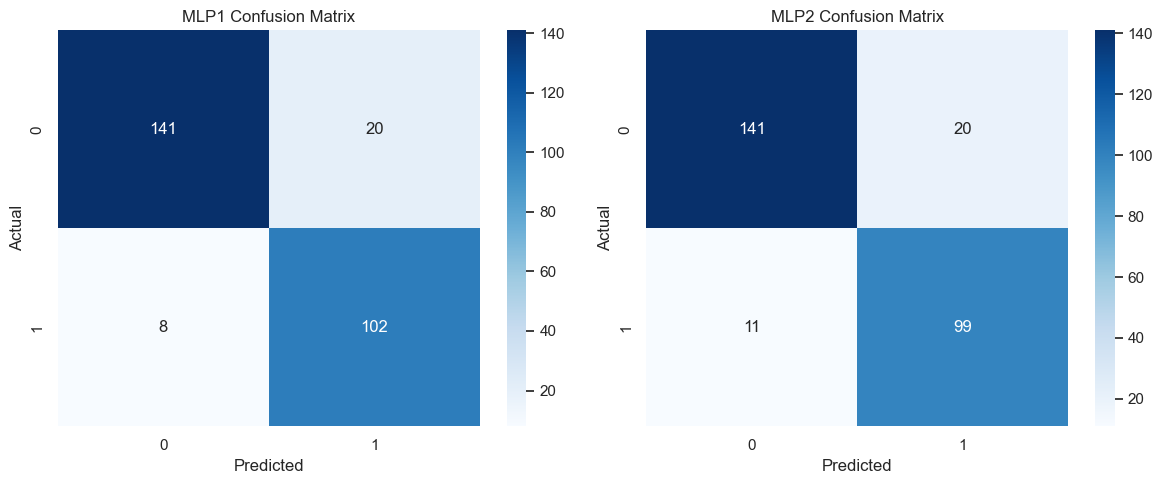

In [14]:
# Confusion matrices and side-by-side comparison
cm1 = confusion_matrix(y_test, y1_pred)
cm2 = confusion_matrix(y_test, y2_pred)
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('MLP1 Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('MLP2 Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

## Short analysis
- We trained two MLP (BPN) models with different capacity and learning rate.
- Compare precision/recall/F1 for the positive (phishing) class and check confusion matrices for which model better balances false positives vs false negatives.
- Next steps (optional): hyperparameter search (GridSearchCV), cross-validation, class-weighting if classes are imbalanced, early stopping and learning-rate schedules.